## Ref 

- https://www.kaggle.com/c/bike-sharing-demand

- https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

## Columns :
> - datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + 
         Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [23]:
# load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import matplotlib.pyplot as plt

#import missingno as msno

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/g_dash/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [24]:
# load CSVs

df_train = pd.read_csv('~/Kaggle.com_mini_project/bike_sharing/data/train.csv')
df_test = pd.read_csv('~/Kaggle.com_mini_project/bike_sharing/data/test.csv')
sampleSubmission = pd.read_csv('~/Kaggle.com_mini_project/bike_sharing/data/samplesubmit.csv')

In [25]:
df_train.shape

(10886, 12)

In [26]:
df_train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


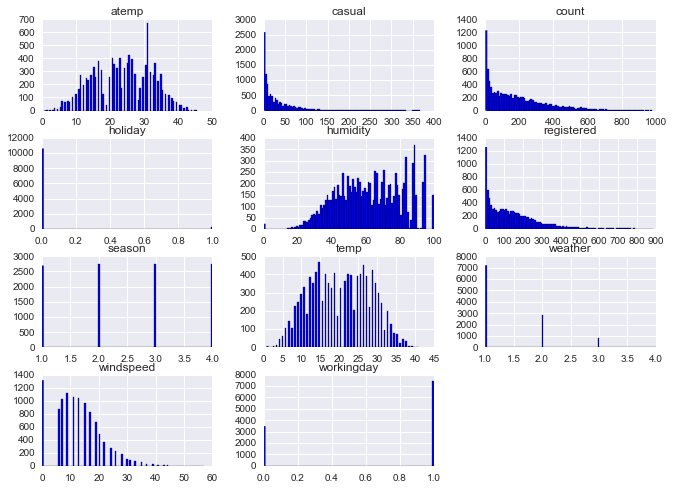

In [27]:
# histagram on train data 

df_train.hist(bins=100, figsize=(11,8),color='blue')
plt.show()

In [66]:
### leakage variables ###

# casual and registered are leakage variables, so I would remive these 2 
# variables later when modeling 
# (count = casual + registered )
df_train[['casual','registered','count']].head(10)

,casual,registered,count
0,3,13,16
1,8,32,40
2,5,27,32
3,3,10,13
4,0,1,1
5,0,1,1
6,2,0,2
7,1,2,3
8,1,7,8
9,8,6,14


## 0) Feature Extract

Simply get analysis required time data : weekday / month / time ..  
and season from raw dataset. Will do further feature engineering in 
modeling part 

In [29]:
#df_train.head(3)

In [30]:
# help functions 


####### 
# extract features 

def get_date(x):
    return x.split(" ")[0]

def get_year(x):
    return x.split(" ")[0].split("-")[0]

def get_month(x):
    return x.split(" ")[0].split("-")[1]

def get_weekday(x):
    # DatetimeIndex.weekday
    # The day of the week with Monday=0, Sunday=6
    # mon. = 0, tue.=1, wed.=2, thurs. = 3 , fri. = 4, sat. =5 , sun. = 6 
    return pd.to_datetime(x.split(" ")[0]).weekday()

def get_time(x):
    return x.split(" ")[1]

def get_hour(x):
    return x.split(" ")[1].split(":")[0]

#def get_season(x):
#    return x.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })

####### 



In [31]:
# get features extracted

df_train['date'] = df_train['datetime'].apply(lambda x :get_date(x)  )
df_train['time'] = df_train['datetime'].apply(lambda x :get_time(x)  )
df_train['hour'] = df_train['datetime'].apply(lambda x :get_hour(x)  )
df_train['year'] = df_train['datetime'].apply(lambda x :get_year(x)  )
df_train['month'] = df_train['datetime'].apply(lambda x :get_month(x)  )
df_train['weekday'] = df_train['datetime'].apply(lambda x :get_weekday(x)  )
df_train['season_'] = df_train['season'].map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })


In [32]:
df_train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time,hour,year,month,weekday,season_
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,00:00:00,00,2011,01,5,Spring
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,01:00:00,01,2011,01,5,Spring


## 1) Check Data Quality 

Here we plot boxplot to birdview data outliers and distributions.
- Fig 1. (count) imply there are `lots of outliers` greater than top quartile limit that skews the counts distribution to right.

- Fig 2. (season) shows that sping (blu one) has relatively lower count. 

- Fig 3. (weekday) counts distribute averagely in all week days 

- Fig 4. (hour) Median of Counts are relatively higher at 7AM - 8AM and   5PM - 6PM which make sense since students and worker go / off work in the period 

- Fig 5. (workday) Most outliers are from "`workday`", maybe the system is much more busy within Mon.-Fri.

- Fig 6. (month) counts are relatively higher in June-Sep. which fit Fig 2. 

- Fig 8. (humidity) The system are much busy (lots counts) when humidity low : Users tend ride bicycle more when in mild weather

- Fig 9. (temperature) An interesting phenomenon : higher temp, higer counts, have to check why users still ride lots bike in hot weather 


In [33]:
df_train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'date', 'time', 'hour', 'year', 'month', 'weekday', 'season_'],
      dtype='object')

In [34]:
#fig, axes = plt.subplots(nrows=1,ncols=1)
#fig.set_size_inches(12, 10)
#sns.boxplot(data=df_train,y="count",x="weekday",orient="v")

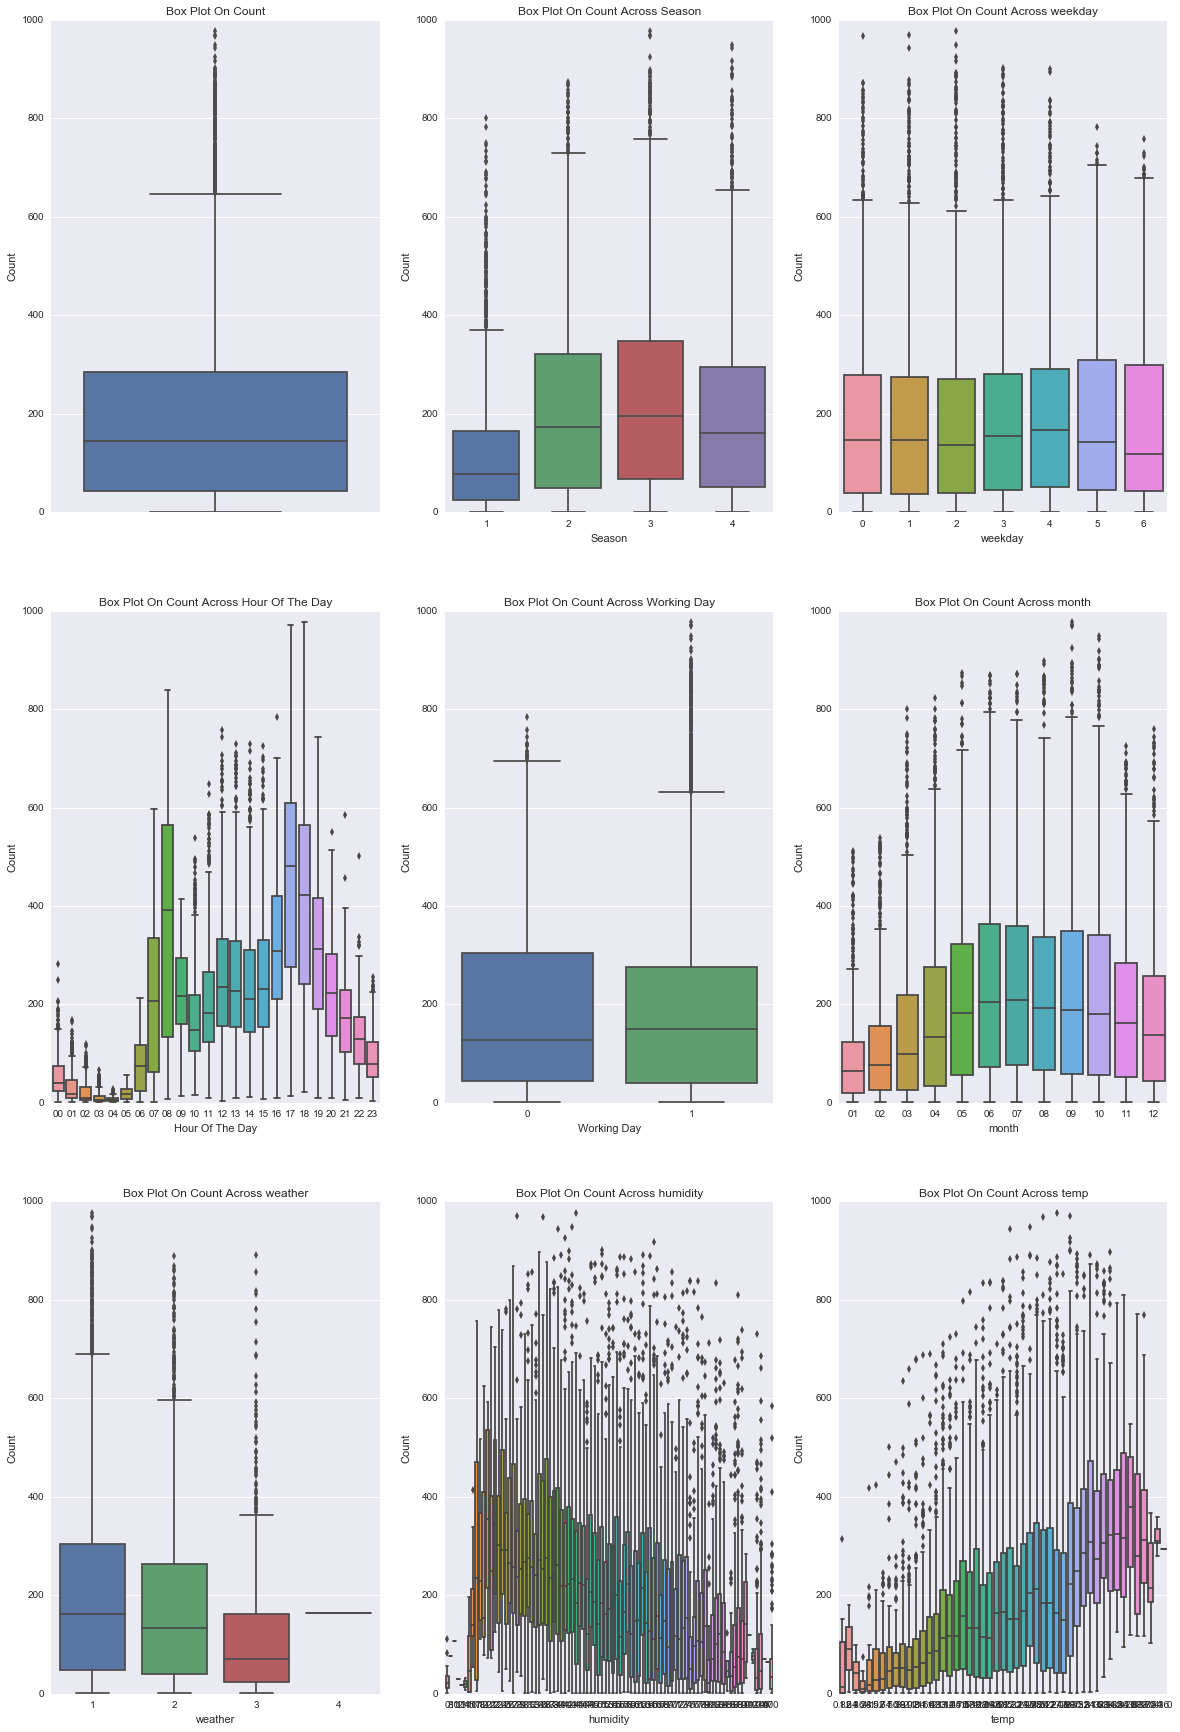

In [35]:
# boxplot on counts VS features 

fig, axes = plt.subplots(nrows=3,ncols=3)
fig.set_size_inches(20, 30)
sns.boxplot(data=df_train,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=df_train,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=df_train,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=df_train,y="count",x="workingday",orient="v",ax=axes[1][1])

sns.boxplot(data=df_train,y="count",x="weekday",orient="v" ,ax=axes[0][2])
sns.boxplot(data=df_train,y="count",x="month",orient="v" ,ax=axes[1][2])
sns.boxplot(data=df_train,y="count",x="weather",orient="v" ,ax=axes[2][0])
sns.boxplot(data=df_train,y="count",x="humidity",orient="v" ,ax=axes[2][1])
#sns.boxplot(data=df_train,y="count",x="atemp",orient="v" ,ax=axes[2][1])
sns.boxplot(data=df_train,y="count",x="temp",orient="v" ,ax=axes[2][2])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

axes[0][2].set(xlabel='weekday', ylabel='Count',title="Box Plot On Count Across weekday")
axes[1][2].set(xlabel='month', ylabel='Count',title="Box Plot On Count Across month")
axes[2][0].set(xlabel='weather', ylabel='Count',title="Box Plot On Count Across weather")
axes[2][1].set(xlabel='humidity', ylabel='Count',title="Box Plot On Count Across humidity")
#axes[2][1].set(xlabel='atemp', ylabel='Count',title="Box Plot On Count Across atemp")
axes[2][2].set(xlabel='temp', ylabel='Count',title="Box Plot On Count Across temp")


## 2) Check Correlation 

It is important to know how dependent variables (y) are affected by 
features and how feature influence each other.
So here I plot a correlation heatmap :

- A. casual and registered are leakage variables need to be dropped out
     (count = casual + registered )
- B. temp and atemp has `too strong` correlation which would cause 
    `multicollinearity`, need to drop atemp in following process 
- C. temp and humidity are `not bad` features, with OK correlation with counts respectively   


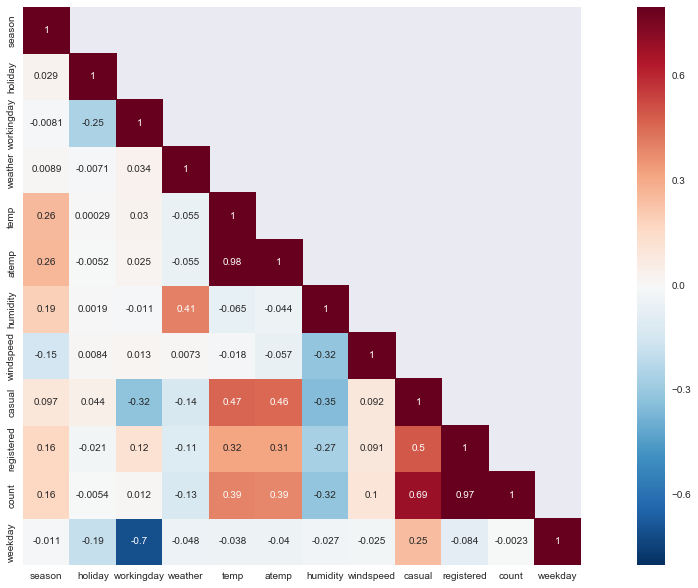

In [65]:
corrmatrix = df_train.corr()
mask = np.array(corrmatrix)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

In [37]:
#df_train.columns

selected_columns = ['season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
        'hour', 'weekday', 'season_', 'year', 'month']

In [38]:
#df_train_ = df_train[selected_columns]
#np.abs(df_train_.corr()).sort('count',ascending=False)['count'][1:]

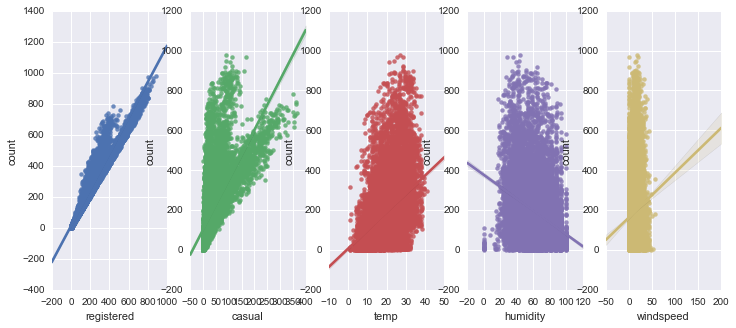

In [69]:
# plot regression on TOP5 features correlate counts 

fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(ncols=5)
fig.set_size_inches(12, 5)

sns.regplot(x="registered", y="count", data=df_train,ax=ax1)
sns.regplot(x="casual", y="count", data=df_train,ax=ax2)
sns.regplot(x="temp", y="count", data=df_train,ax=ax3)
sns.regplot(x="humidity", y="count", data=df_train,ax=ax4)
sns.regplot(x="windspeed", y="count", data=df_train,ax=ax5)

## 3) Check distribution

Here I use "QQ plot" to check if data are in `normal distribution`,
since most ML models require dependent variable to be `Normal`.
This dataset looks not really in "`normal distribution `" even remove outliers/logarithm/square root them.

`(If data distribute normally, its qqplot would look like a straight line )`




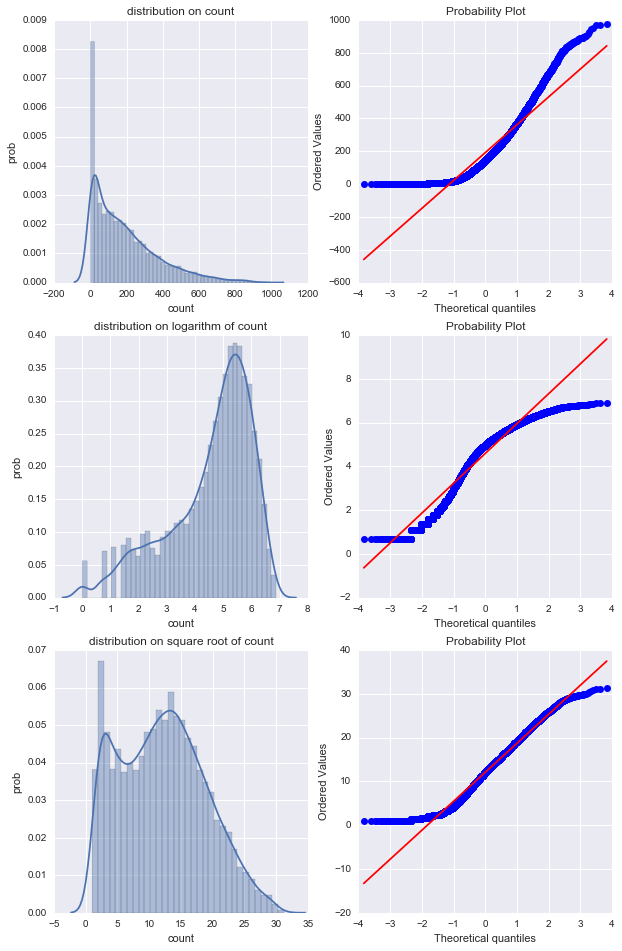

In [42]:
## check if data distribute Normal 
## Q-Q plot  (quantile-quantile plot )
## https://stats.stackexchange.com/questions/52293/r-qqplot-how-to-see-whether-data-are-normally-distributed
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html
## https://stackoverflow.com/questions/13865596/quantile-quantile-plot-using-scipy

from scipy import stats
import matplotlib.pyplot as plt


fig,axes = plt.subplots(ncols=2,nrows=3)
fig.set_size_inches(10, 16)

sns.distplot(df_train["count"],ax=axes[0][0])
stats.probplot(df_train["count"], dist='norm', fit=True, plot=axes[0][1])

sns.distplot(np.log(df_train["count"]),ax=axes[1][0])
stats.probplot(np.log1p(df_train["count"]), dist='norm', fit=True, plot=axes[1][1])

sns.distplot(np.sqrt(df_train["count"]),ax=axes[2][0])
stats.probplot(np.sqrt(df_train["count"]), dist='norm', fit=True, plot=axes[2][1])

axes[0][0].set(xlabel='count', ylabel='prob',title="distribution on count") 
axes[1][0].set(xlabel='count', ylabel='prob',title="distribution on logarithm of count")
axes[2][0].set(xlabel='count', ylabel='prob',title="distribution on square root of count")

